In [16]:
# Math and data
import numpy as np
import pandas as pd
import polars as pl
import math
from scipy.stats import norm, gamma
# Utilities
import re
import utility as util
# Plotting
import matplotlib.pyplot as plt

# use seaborn style for matplotlib
plt.style.use("seaborn")

fig_dir = "results/img/"
data_dir = "results/"

plasma_cmap = plt.get_cmap("plasma")

(0.0, 10.0, 0.0, 1.0)

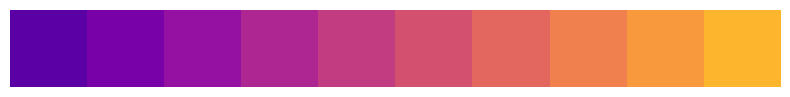

In [56]:
# Test util.get_colors_from_cmap
colors = util.get_colors_from_cmap(10, plasma_cmap)
# Plot the colors with a square each
fig, ax = plt.subplots(figsize=(10, 1))
ax.imshow([colors], extent=[0, 10, 0, 1])
ax.axis("off")

Review word count bins: [16, 80, 32, 48, 64, 96, 15, 95, 31, 79, 63, 47, 30, 78, 46, 94, 14, 62, 93, 45, 77, 61, 29, 76, 92, 28, 60, 44, 75, 27, 91, 43, 59, 42, 90, 26, 74, 58, 57, 41, 89, 73, 25, 40, 24, 56, 72, 88, 39, 23, 71, 87, 55, 22, 38, 54, 86, 70, 85, 21, 69, 37, 53, 84, 20, 68, 52, 36, 83, 99, 51, 35, 19, 67, 50, 66, 82, 98, 34, 18, 97, 33, 17, 65, 49, 81]
Summary word count bins: [14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4]
ax2_labels: Gamma
(α=1.53, β=16.67)
ax_labels: Word count distribution
ax2_labels: Gamma
(α=3.45, β=1.35)
ax_labels: Word count distribution


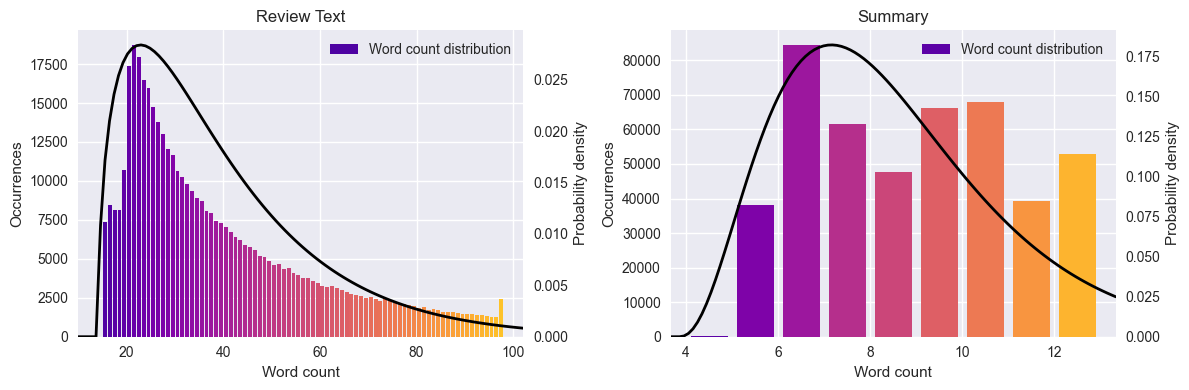

In [113]:
# Histogram plots, and distribution fits

df_pruned = util.load_dataset(util.Paths.arts, util.DatasetType.PRUNED)

# plot the review and summary word count distribution

review_word_count = df_pruned['reviewText'].apply(lambda x: len(x.split()))
summary_word_count = df_pruned['summary'].apply(lambda x: len(x.split()))

r_counts = review_word_count.value_counts()
s_counts = summary_word_count.value_counts()

# print(f"Review word count: {r_counts}")
# print(f"Summary word count: {s_counts}")

r_bins = review_word_count.value_counts()["reviewText"].to_list()
s_bins = summary_word_count.value_counts()["summary"].to_list()

print(f"Review word count bins: {r_bins}")
print(f"Summary word count bins: {s_bins}")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for ax, (data, lengths), title in zip(ax.flatten(), [(review_word_count.to_list(), r_bins), (summary_word_count.to_list(), s_bins)], ['Review Text', 'Summary']):
    # Plot histogram
    n, bins, patches = ax.hist(data, bins=range(np.min(lengths), np.max(lengths)), rwidth=0.8, label=f"Word count distribution")
    for c, p in zip(util.get_colors_from_cmap(len(patches), plasma_cmap), patches):
        plt.setp(p, 'facecolor', c)

    # Distrubution fitting
    xmin, xmax = ax.get_xlim()
    # # Fit and plot normal distribution scaled to histogram
    # mu, std = norm.fit(data)
    # x = np.linspace(xmin, xmax, 100)
    # p = norm.pdf(x, mu, std)
    # ax.plot(x, len(data) * p, 'k', linewidth=2, label=f"Normal distribution fit (μ={mu:.2f}, σ={std:.2f})")

    # # Fit and plot lognormal distribution scaled to histogram
    # mu, std = norm.fit(np.log(data))
    # # xmin, xmax = ax.get_xlim()
    # x = np.linspace(xmin, xmax, 100)
    # p = norm.pdf(np.log(x), mu, std)
    # ax.plot(x, len(data)/25 * p, 'g', linewidth=2, label=f"Lognormal distribution fit (μ={mu:.2f}, σ={std:.2f})")

    # Fit and plot gamma distribution scaled to histogram
    # Make the y axis for the fitting on the right side
    ax2 = ax.twinx()
    # Fit the gamma distribution
    shape, loc, scale = gamma.fit(data)
    # xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = gamma.pdf(x, shape, loc, scale)
    dist = ax2.plot(x, p, 'k', linewidth=2, label=f"Gamma\n(α={shape:.2f}, β={scale:.2f})")
    ax2.set_ylabel('Probability density')
    ax2.set_ylim([0, ax2.get_ylim()[1]])
    # Legend at the upper right, but moved down to accomodate the second y axis
    ax2_labels = dist[0].get_label()
    print(f"ax2_labels: {ax2_labels}")
    ax2.grid(False)

    # Plot extra
    ax.set_title(title)
    ax.set_xlabel('Word count')
    ax.set_ylabel('Occurrences')
    ax.set_xlim([xmin, xmax])
    # get label from histogram
    ax_labels = patches[0].get_label()
    print(f"ax_labels: {ax_labels}")
    ax.legend(loc="upper right")

fig.tight_layout()
plt.show()

# save figure as png and pdf
fig.savefig(fig_dir + "review_summary_word_count_distribution.png", dpi=300)
fig.savefig(fig_dir + "review_summary_word_count_distribution.pdf")

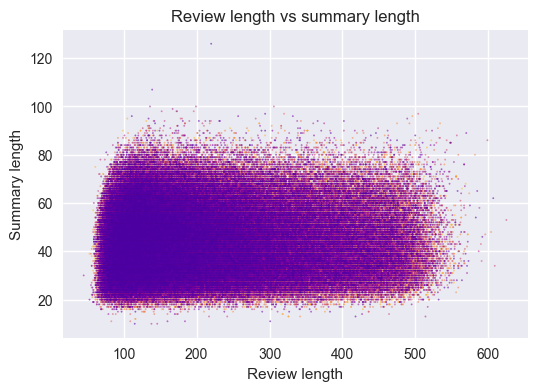

In [72]:
# Review and summary word count correlation

df_pruned = util.load_dataset(util.Paths.arts, util.DatasetType.PRUNED)

# Plot the review and summary length correlation
# I.e. the length of the review and the length of the summary on the same plot to see if there is a correlation

review_length = df_pruned['reviewText'].apply(lambda x: len(x))
summary_length = df_pruned['summary'].apply(lambda x: len(x))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Summary length on y-axis and review length on x-axis
colors = util.get_colors_from_cmap(len(df_pruned), plasma_cmap)
colors.reverse()
ax.scatter(review_length.to_list(), summary_length.to_list(), s=1, alpha=0.5, label="Review length vs summary length", c=colors)

# # Plot trendline
# z = np.polyfit(review_length.to_list(), summary_length.to_list(), 1)
# p = np.poly1d(z)
# ax.plot(review_length.to_list(), p(review_length.to_list()), "r--", label=f"Trendline (slope={z[0]:.2f})")

# Plot extra
ax.set_title("Review length vs summary length")
ax.set_xlabel('Review length')
ax.set_ylabel('Summary length')

fig.tight_layout()
plt.show()

# save figure as png and pdf
fig.savefig(fig_dir + "review_summary_length_correlation.png", dpi=300)
fig.savefig(fig_dir + "review_summary_length_correlation.pdf")

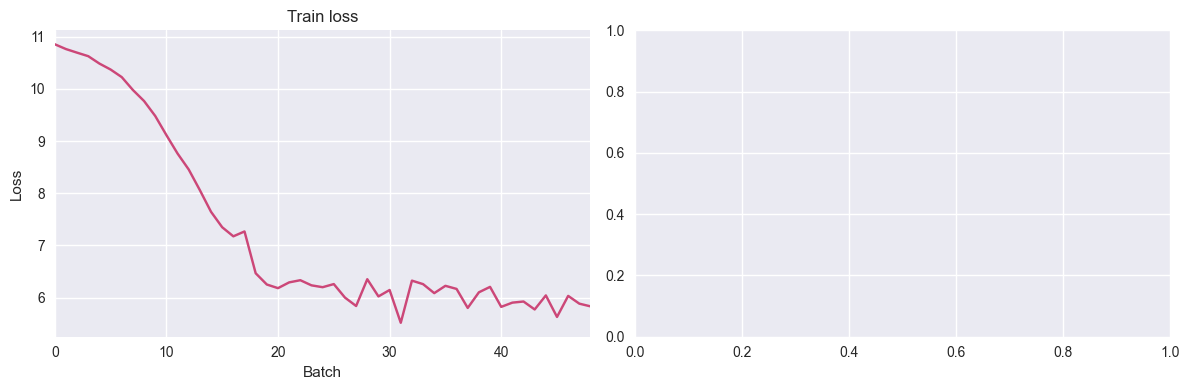

In [76]:
# Loss and accuracy over time

df = pl.read_csv(data_dir + "runs_027_batch_size_32_learning_rate_0_0005_teacher_forcing_rati.csv")

colors = util.get_colors_from_cmap(1, plasma_cmap)

# Plot the loss and accuracy over time
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for ax, data, title, color in zip(ax.flatten(), [df['Value']], ['Train loss'], colors):
    # Plot loss
    ax.plot(data.to_list(), label=title, c=color)

    # Plot extra
    ax.set_title(title)
    ax.set_xlabel("Batch")
    ax.set_ylabel("Loss")
    ax.set_xlim([0, data.len()-1])

fig.tight_layout()
plt.show()

# save figure as png and pdf
fig.savefig(fig_dir + "train_loss_accuracy.png", dpi=300)
fig.savefig(fig_dir + "train_loss_accuracy.pdf")

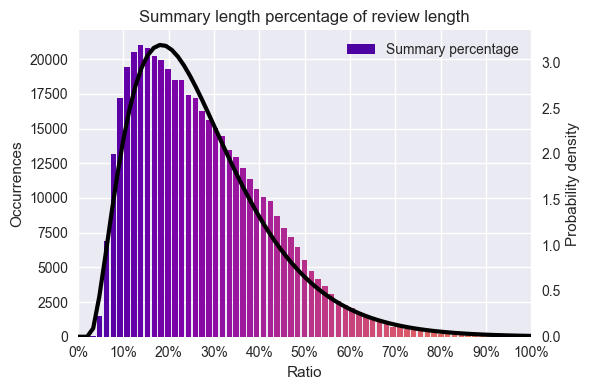

In [90]:
# Histogram of review and summary length ratio

df_pruned = util.load_dataset(util.Paths.arts, util.DatasetType.PRUNED)

# Plot the review and summary length ratio

review_length = df_pruned['reviewText'].apply(lambda x: len(x))
summary_length = df_pruned['summary'].apply(lambda x: len(x))

length_ratio = summary_length / review_length

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

bin_count = 80

# Plot histogram
counts, bins, patches = ax.hist(length_ratio, bins=bin_count, rwidth=0.8, label=f"Summary percentage")
colors = util.get_colors_from_cmap(bin_count, plasma_cmap)
for c, p in zip(colors, patches):
    plt.setp(p, 'facecolor', c)

# Fit and plot gamma distribution scaled to histogram
# Make the y axis for the fitting on the right side
ax2 = ax.twinx()
shape, loc, scale = gamma.fit(length_ratio)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = gamma.pdf(x, shape, loc, scale)
ax2.plot(x, p, 'k', linewidth=3, label=f"Gamma\n(shape={shape:.2f}, scale={scale:.2f})")
ax2.set_ylabel('Probability density')
ax2.grid(False)
ax2.set_ylim([0, ax2.get_ylim()[1]])

# Plot extra
ax.set_title("Summary length percentage of review length")
ax.set_xlabel('Ratio')
ax.set_ylabel('Occurrences')
ax.set_xlim([0, 1])
ax.legend(loc='upper right')

# Rescale x labels to be percentages
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xticklabels([f"{x*100:.0f}%" for x in np.arange(0, 1.1, 0.1)])

fig.tight_layout()

plt.show()

# save figure as png and pdf
fig.savefig(fig_dir + "review_summary_length_ratio.png", dpi=300)
fig.savefig(fig_dir + "review_summary_length_ratio.pdf")

In [ ]:
# Make the y axis for the fitting on the right side